# Data Exploration

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [13]:
data = pd.read_csv("../data/raw/price_data.csv")
data["timestamp"] = pd.to_datetime(data["timestamp"], unit="ms").dt.strftime("%m-%d-%Y")
data.set_index("timestamp", inplace=True)
print(data.shape)
data.head()

(180, 13)


,fire_rune,water_rune,air_rune,earth_rune,mind_rune,body_rune,death_rune,nature_rune,chaos_rune,law_rune,cosmic_rune,blood_rune,soul_rune
timestamp,,,,,,,,,,,,,
05-17-2024,4,4,4,4,2,5,111,93,59,119,85,199,199
05-18-2024,4,4,4,4,2,5,111,92,59,119,80,199,196
05-19-2024,4,4,4,4,2,5,111,90,60,119,76,200,195
05-20-2024,4,4,4,4,2,5,112,92,60,119,72,201,196
05-21-2024,4,4,4,4,2,4,114,92,60,119,71,203,198


In [14]:
print(data.describe())

        fire_rune  water_rune    air_rune  earth_rune   mind_rune   body_rune  \
count  180.000000  180.000000  180.000000  180.000000  180.000000  180.000000   
mean     4.255556    4.177778    4.261111    4.122222    2.127778    6.072222   
std      0.437390    0.383392    0.440466    0.328456    0.351065    1.513553   
min      4.000000    4.000000    4.000000    4.000000    2.000000    2.000000   
25%      4.000000    4.000000    4.000000    4.000000    2.000000    5.000000   
50%      4.000000    4.000000    4.000000    4.000000    2.000000    6.000000   
75%      5.000000    4.000000    5.000000    4.000000    2.000000    7.000000   
max      5.000000    5.000000    5.000000    5.000000    4.000000   10.000000   

       death_rune  nature_rune  chaos_rune    law_rune  cosmic_rune  \
count  180.000000   180.000000  180.000000  180.000000   180.000000   
mean   167.650000   111.833333   97.005556  141.927778   103.561111   
std     30.841363    12.475003   14.739639   19.678997   

**Plots**  
Line graph, distribution plot, and heat map

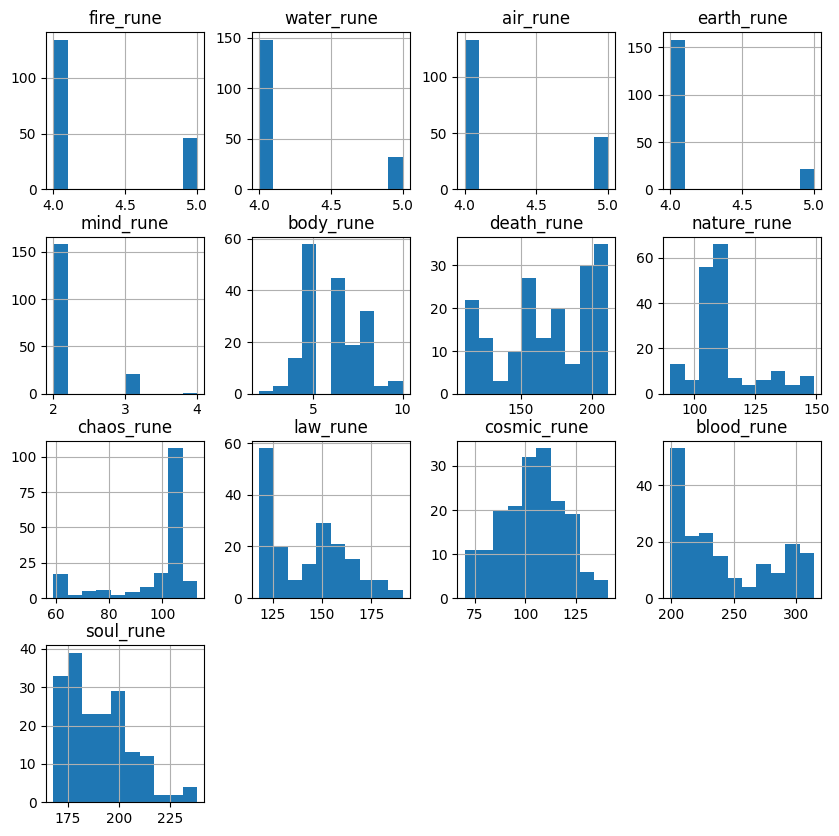

In [15]:
data.hist(figsize=(10,10))
plt.title("Histogram of Daily Runes Prices")
plt.show()

We are looking for runes where we can make the largest profit. This means finding runes with the largest difference between the lowest price and the highest price. We also want a rune where there are large volumes traded with the lowest and highest price. If the volumes traded are low, that means the chance of our trade going through would drop. 

According to the histograms above, we can see that fire, water, earth, air, and mind runes all vary within 1 gold piece (meaning you can only make 1gp profit) making these runes not very profitable to trade. Of the runes left, death runes features a large price disparity, meaning large profits, and large volumes are traded in the lowest price and the highest price. 

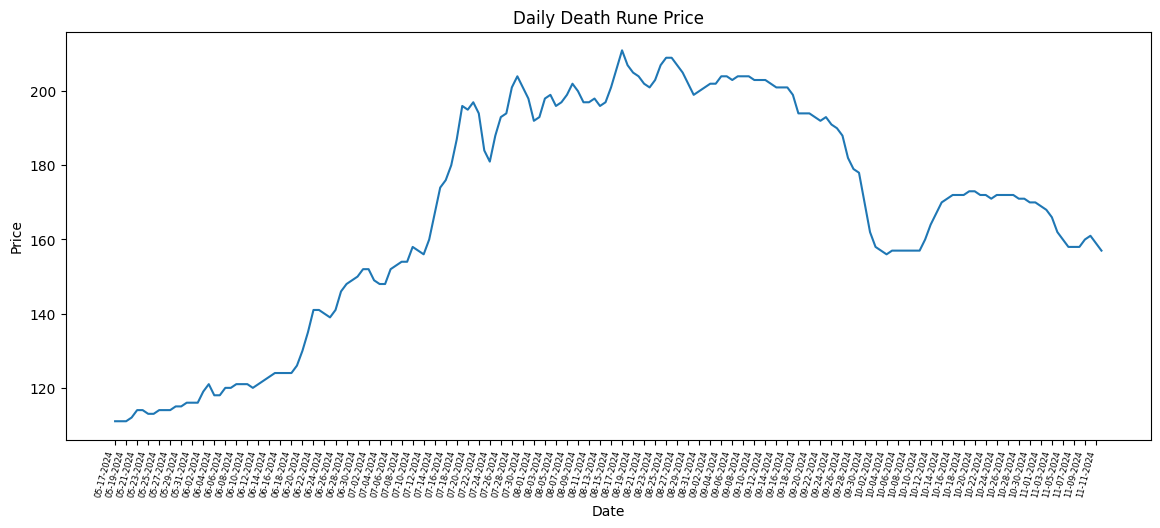

In [16]:
plt.figure(figsize=(14,6))

tick_position = data.index[::2]
plt.plot(data.index, data["death_rune"])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1)) # Adjust the interval as needed
plt.gcf().autofmt_xdate()

plt.title("Daily Death Rune Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=75, ticks=tick_position, labels=tick_position, fontsize=6)
plt.show()

In [17]:
# normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
normalized_df = pd.DataFrame(normalized_data, columns=data.columns)

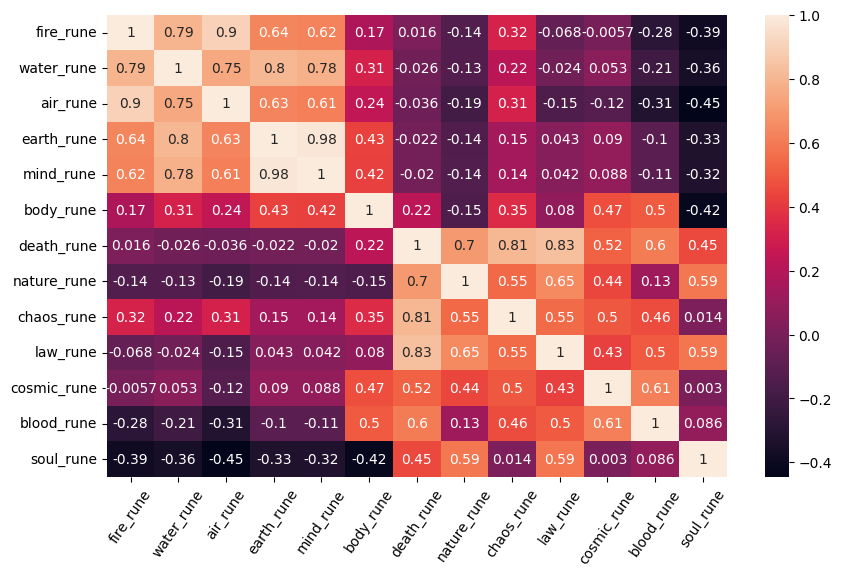

In [18]:
#correlation matrix
corr_matrix = normalized_df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=55)
plt.show()

# Model Analysis  
Now that we know that we're going to try to predict for death runes, we'll need to tweak our data. We'll only be looking at the data for death runes, and we'll need to change our data so that our target data is the price at each day, and the training data are the past prices up to that day. We don't want our model to predict the target day's price based on future since we won't have access to that information in the real world.

We also only have 6 months of data meaning that each y will have a differing number of features (ie the 100th day will have 99 features, the 101st will have 100 features). To counter this, we will restrict all targets to have the same number of features. If the target does not have the required number of features, we will drop those targets. 

In [19]:
def enrich_data(data, target_item, feature_count):
    # Returns X and y where y is the target price of that day, and X contains all the prices before that day
    item_prices = data[target_item]
    X, y = [], []
    for i, price in enumerate(item_prices):
        if i < feature_count:
            continue
        y.append(price)
        temp = list(item_prices[i-feature_count:i])
        X.append(temp)

    return pd.DataFrame(X), pd.Series(y)

In [20]:
feature_count = 15
X, y = enrich_data(data, "death_rune", feature_count)
print(y.shape)
X.head

(165,)


<bound method NDFrame.head of       0    1    2    3    4    5    6    7    8    9    10   11   12   13   14
0    111  111  111  112  114  114  113  113  114  114  114  115  115  116  116
1    111  111  112  114  114  113  113  114  114  114  115  115  116  116  116
2    111  112  114  114  113  113  114  114  114  115  115  116  116  116  119
3    112  114  114  113  113  114  114  114  115  115  116  116  116  119  121
4    114  114  113  113  114  114  114  115  115  116  116  116  119  121  118
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
160  172  172  172  172  171  171  170  170  169  168  166  162  160  158  158
161  172  172  172  171  171  170  170  169  168  166  162  160  158  158  158
162  172  172  171  171  170  170  169  168  166  162  160  158  158  158  160
163  172  171  171  170  170  169  168  166  162  160  158  158  158  160  161
164  171  171  170  170  169  168  166  162  160  158  158  158  160  161  159

[165 rows x 15 column

In [21]:

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

# fit
model = RandomForestRegressor(n_estimators=500, random_state=42, max_features=feature_count)
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# mse and r2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
n = len(y_test) # number of observations
p = X_train.shape[1] # number of features
r2_adj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
cv = KFold(n_splits = 5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring="r2")

print(f"y_pred: {y_pred}")
print("MSE: ", mse)
print(f"R2: {r2}")
print(f"r2 adjusted: {r2_adj}")
print(f"Cross Validation Score: {cv_scores}")
print(f"Mean Cross-Validated R2: {cv_scores.mean()}")

y_pred: [120.69  122.384 125.424 126.902 127.094 130.626 140.55  148.5   148.44
 149.064 193.732 190.242 195.098 201.836 196.69  196.72  207.374 207.558
 201.822 202.78  202.884 201.406 192.748 157.288 157.434 162.578 168.324
 172.298 171.44  168.9   167.284 160.562 157.638]
MSE:  4.891898787878794
R2: 0.9939994348025898
r2 adjusted: 0.9887048184519337
Cross Validation Score: [0.99399943 0.99338793 0.98662388 0.99050712 0.97569347]
Mean Cross-Validated R2: 0.9880423678186283


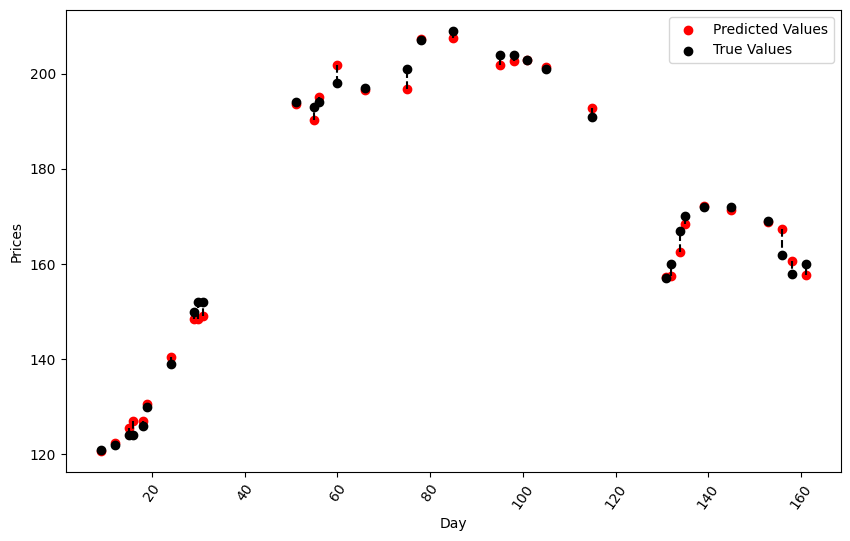

In [22]:
plt.figure(figsize=(10,6))
for i in range(len(y_test)):
    plt.plot([y_test.index[i], y_test.index[i]], [y_pred[i], y_test.iloc[i]], color="black", linestyle="--")
plt.scatter(y_test.index, y_pred, label="Predicted Values", color="red")
plt.scatter(y_test.index, y_test, label="True Values", color="black")

plt.xticks(rotation=55)
plt.xlabel("Day")
plt.ylabel("Prices")

plt.legend()
plt.show()

# Conclusion  
Random Forest Tree seems to have a very high mean cross validated r2 score meaning that it is able to predict the trends very well. 